# State Farm, Attempt 2

### 1. Setup and Imports

Assumption: Data is already categorized into test, train, and valid

In [47]:
#GPU Setup
from theano.sandbox import cuda
cuda.use('gpu0')

In [48]:
#Plotting
%matplotlib inline

In [49]:
#Paths
import os, sys
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir + '/data/statefarm'
path = DATA_HOME_DIR + '/'
test_path = DATA_HOME_DIR + '/test/'
results_path = DATA_HOME_DIR + '/results/'
train_path = DATA_HOME_DIR + '/train/'
valid_path = DATA_HOME_DIR + '/valid/'

In [50]:
#Imports
from utils import *
from vgg16 import Vgg16

### 2. Setup Batches

In [51]:
#Initialize VGG
vgg = Vgg16()

In [52]:
#Constants

#Batch Size
batch_size = 64

#Number of Epochs
no_of_epochs = 3

In [53]:
#Grab batches to finetune model
batches = vgg.get_batches(train_path, batch_size = batch_size)
val_batches = vgg.get_batches(valid_path, batch_size = batch_size*2)

Found 21424 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


### 3. Finetune and Train VGG

In [54]:
#Finetune against batches
vgg.finetune(batches)

In [55]:
#Set Learning Rate
vgg.model.optimizer.lr = 0.001
#This can be changed between epochs

In [56]:
latest_weights_filename = None #Init variable
#For Loop over Epochs
for epoch in range(no_of_epochs):
    #Fit one epoch at a time to create backup weight files in case of overfitting
    print 'Epoch: %d' %epoch
    print 'Learning Rate: %.4f' %vgg.model.optimizer.lr
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%dv2.h5' %epoch
    vgg.model.save_weights(results_path + latest_weights_filename)
print 'Complete %d fit operations' %no_of_epochs

Epoch: 0
Learning Rate: 0.0010
Epoch 1/1
21424/21424 [==============================] - 574s - loss: 1.8406 - acc: 0.4750 - val_loss: 0.5558 - val_acc: 0.8290
Epoch: 1
Learning Rate: 0.0010
Epoch 1/1
21424/21424 [==============================] - 575s - loss: 1.0632 - acc: 0.6586 - val_loss: 0.4462 - val_acc: 0.8740
Epoch: 2
Learning Rate: 0.0010
Epoch 1/1
21424/21424 [==============================] - 576s - loss: 0.9128 - acc: 0.7076 - val_loss: 0.3558 - val_acc: 0.8980
Complete 3 fit operations


Conclusion: So far, this model is *worse* than random guessing. I think I'm misunderstanding how the VGG model works and how to use it properly. There need to be more layers. (9% Accuracy)

Changes: Removed overlaps between training set and validation set. Not sure why, but this seems to have drastically improved the accuracy rate (when I would expect the opposite?). Regardless, there should not have been overlaps in the first place. (32-36% Accuracy w LR = 0.01, saved at ft0.h5, ft1.h5, ft2.h5). ONLY PREDICTS 0 or 1

Changes: Saved at ft0v2.h5, etc. Changed LR to 0.001 and overwrote v2.

Results:

         Epoch 0: Acc 0.475, val_acc 0.829

         Epoch 1: Acc 0.659, val_acc 0.8740
         
         Epoch 2: Acc 0.7076, val_acc 0.8980
         
Conclusion: Issue is in the rounding code and visualization code!

### 4. Predictions, Visualizations, and Tweaking of VGG 
#### THIS IS WHERE THE ERRORS ARE. Somehow it is rounding to binary classification, I believe

In [63]:
#Load Weights
vgg.model.load_weights(results_path + latest_weights_filename)
#Pull Validation Set Probabilities
val_batches, probs = vgg.test(valid_path, batch_size = batch_size)

Found 1000 images belonging to 10 classes.


In [75]:
#Setup predictions for debugging
filenames = val_batches.filenames
expected_labels = val_batches.classes #0-9
#Round our predictions for comparison
#our_predictions = probs[:,0] 
#our_labels = np.round(1-our_predictions)

I think the rounding lines are being problematic! (Commented out for now)

#### Solution: Formatting "our_labels"

our_predictions a 1000x10 matrix s.t. (i,j) is the probability example i is label j

expected_values is a 1000x1 vector s.t. (i) is the integer class of example i

Solution: Need to convert our_predictions from logical matrix to vector of integers

###### Step 1: Iterate over each row of predictions
###### Step 2: use np.argmax to find the index of the highest prediction of that row
###### Step 3: Save the np.argmax value to our_labels
###### Step 4: Increment and repeat
###### -Now it is in the format to compare with expected_labels

our_labels is a 1000x1 vector s.t. (i) is the integer of the predicted class of example i

In [84]:
our_predictions = probs
our_labels = np.zeros(1000)
#Can't round because sometimes there will be nothing with a probability greater than 0.5
#our_predictions_rounded = np.round(our_predictions)
#print our_predictions_rounded[0:100]
i = 0
for rows in probs:
    #Iterate over each example
    our_labels[i] = np.argmax(rows)
    i +=1
print our_labels

[ 0.  9.  5.  0.  0.  0.  0.  9.  0.  0.  9.  0.  0.  9.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  9.  0.  0.  0.  0.  5.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  9.  0.  4.  0.  2.  0.  0.  9.  0.  0.
  0.  0.  0.  0.  0.  2.  0.  0.  0.  9.  0.  9.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  2.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  3.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  5.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  5.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.
  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  2.  4.  2.  2.  2.  2.  2.  2

In [85]:
#Setup Image Plotting
from keras.preprocessing import image

def plots_idx(idx, titles=None):
    #Function to plot images by index in the validation set 
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    #Plots is a helper function in utils.py
    
#Number of images to view for each visualization task
n_view = 4

Found 912 correct labels


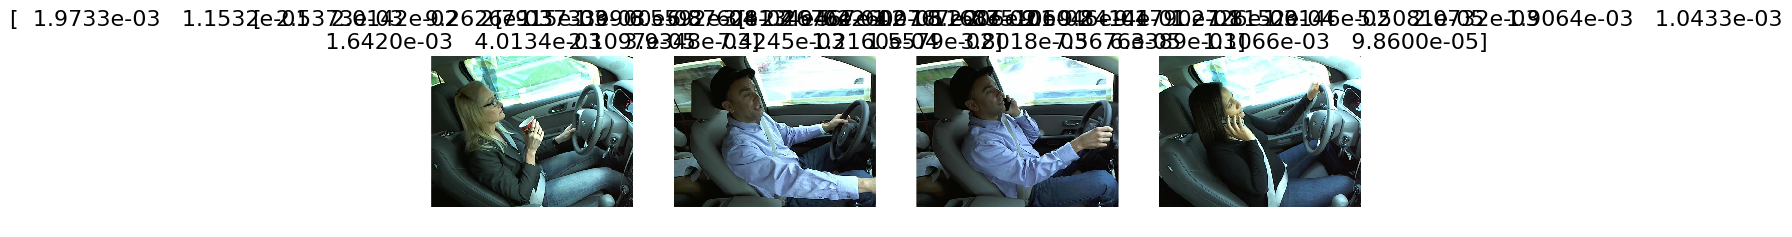

In [86]:
#Random Correct Examples
correct = np.where(our_labels == expected_labels)[0]
print 'Found %d correct labels' %len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 88 incorrect labels


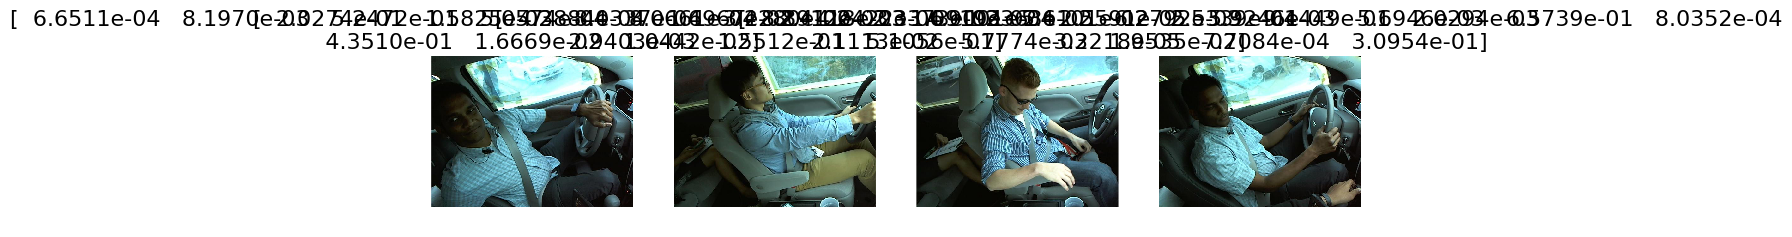

In [92]:
#Random Incorrect Examples
incorrect = np.where(our_labels != expected_labels)[0]
print 'Found %d incorrect labels' %len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

In [ ]:
#Most Uncertain

In [88]:
#Most confident it was cX but was not
x = 7
incorrect_cx = np.where((our_labels == x) & (our_labels != expected_labels))[0]
print 'Found %d examples where predicted %d and it was not' %(len(incorrect_cx), x)
if len(incorrect_cx):
    most_incorrect_cx = np.argsort(our_predictions[incorrect_cx])[::-1][:n_view]
    plots_idx(incorrect_cx[most_incorrect_cx], our_predictions[incorrect_cx][most_incorrect_cx])

Found 0 examples where predicted 7 and it was not


In statefarm-example, the model only predicted 1 or 6 because the learning rate was too high.
Here, it looks like the model mostly predicted 0 or 1.
As of 4pm, 7/11, breakdown is for "Predicted X and not":
c0: 245
c1: 559
c2-9: 0
Conclusion: I think that it's stuck on 2 classes for some reason. We need to convince it that there are 10 classes.

In [ ]:
#Most confident it was cX but it was cY
x = 0
y = 1
incorrect_cx = np.where((our_labels == x) & (our_labels != expected_labels) & (expected_labels == y))[0]
print 'Found %d examples where predicted %d and it was %d' %(len(incorrect_cx), x, y)
if len(incorrect_cx):
    most_incorrect_cx = np.argsort(our_predictions[incorrect_cx])[::-1][:n_view]
    plots_idx(incorrect_cx[most_incorrect_cx], our_predictions[incorrect_cx][most_incorrect_cx])

In [ ]:
#Most confident it was cX and correct

#### Confusion Matrix

In [89]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

[[ 84   1   2   0   2   2   0   0   0   9]
 [  1  95   1   1   0   2   0   0   0   0]
 [  0   0  99   0   1   0   0   0   0   0]
 [  0   2   1  89   5   2   0   0   1   0]
 [  0   1   0   0  97   2   0   0   0   0]
 [  0   0   0   0   0 100   0   0   0   0]
 [  1   3   3   0   0   2  88   0   1   2]
 [  2   0   2   0   1   1   0  89   2   3]
 [  3   1   5   0   2   3   2   0  81   3]
 [  2   3   0   0   0   3   1   0   1  90]]


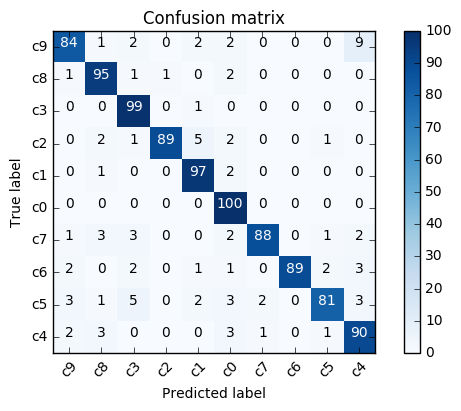

In [90]:
plot_confusion_matrix(cm, val_batches.class_indices)

### 5. Submission to Kaggle

# Building Our Own Model

### 1. Setup batches (without VGG)

### 2. Setup Linear Model

### 3. Build Layers (Hidden, Convolutional, ???)